### Monitoring of the water extent of Lake Neusiedl and the Lacken:
#### Train and Evaluation

In [1]:
# import sys
# from google.colab import drive
# drive.mount('/content/drive')
# sys.path.append('/content/drive/MyDrive/IntProject')

In [2]:

import sys
#
# del sys.modules['data_func']
# del sys.modules['utils']
# del sys.modules['model_v2']


In [3]:
 # pip install yeoda

In [4]:
# pip install tifftools

In [5]:
# pip install fiona

In [6]:
import torch
import copy
import numpy as np
from data_func import merge_files_and_split, ImageDataset, make_list, visualize_augmentations
from model import DownSample, DoubleConv, OutConv, UpSample, UNet
from model_v2 import *
from utils import *
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from torch import optim, nn
import cv2
import time
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from torch.optim import Adam
from torch import permute
from torch import nan_to_num
from torch.nn import BCEWithLogitsLoss
from torchvision.transforms import ToTensor
import rasterio
from torch import nn
from torch import optim, nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
import os
from torch.nn import functional as F

os.environ["NO_ALBUMENTATIONS_UPDATE"] = "1"
import albumentations as A
import warnings
warnings.filterwarnings("ignore", message="y_pred contains classes not in y_true")
import pandas as pd
from torch.cuda.amp import autocast, GradScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt

/Users/nadia/PycharmProjects/InterdisciplinaryProject/utils.py:103: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  grad_scaler = torch.cuda.amp.GradScaler()
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [7]:
# pip install tqdm

In [8]:
# pip install torchvision



### Data Preparation & Augmentation

In [9]:
train_batch_size = 4
val_batch_size = 4
test_batch_size = 4

In [10]:

train_transform = A.Compose([
    A.Resize(256,256 ),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    A.RandomResizedCrop(256,256, scale=(0.8, 1.0),p=0.5),
    A.HorizontalFlip(p=0.8),
    A.VerticalFlip(p=0.8),
     A.Blur(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.8),

], )

test_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),], )


In [12]:
run_colab = False
if run_colab:
    train_set = ImageDataset('./drive/MyDrive/IntProject/train/', './drive/MyDrive/IntProject/train_mask',
                             './drive/MyDrive/IntProject/train_mask_lacken',
                             train_transform)
    trainloader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True, num_workers=1)
    val_set = ImageDataset('./drive/MyDrive/IntProject/val/', './drive/MyDrive/IntProject/val_mask', './drive/MyDrive/IntProject/val_mask_lacken',
                           train_transform)
    valloader = torch.utils.data.DataLoader(val_set, batch_size=val_batch_size, shuffle=True, num_workers=1)
    test_set = ImageDataset('./drive/MyDrive/IntProject/test/', './drive/MyDrive/IntProject/test_mask',
                             './drive/MyDrive/IntProject/test_mask_lacken', train_transform)
    testloader = torch.utils.data.DataLoader(test_set, batch_size=test_batch_size, shuffle=True, num_workers=1)
    dict_file = './drive/MyDrive/IntProject/model_results4.txt'
    model_file = './drive/MyDrive/IntProject/model4.pt'
else:
    train_set = ImageDataset('./train', './train_mask', './train_mask_lacken', train_transform)
    trainloader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True, num_workers=1)
    val_set = ImageDataset('./val', './val_mask', './val_mask_lacken', train_transform)
    valloader = torch.utils.data.DataLoader(val_set, batch_size=val_batch_size, shuffle=True, num_workers=1)
    test_set = ImageDataset('./test', './test_mask', './test_mask_lacken', test_transform)
    testloader = torch.utils.data.DataLoader(test_set, batch_size=test_batch_size, shuffle=True, num_workers=1)
    dict_file = './model_results4.txt'
    model_file = './model4.pt'


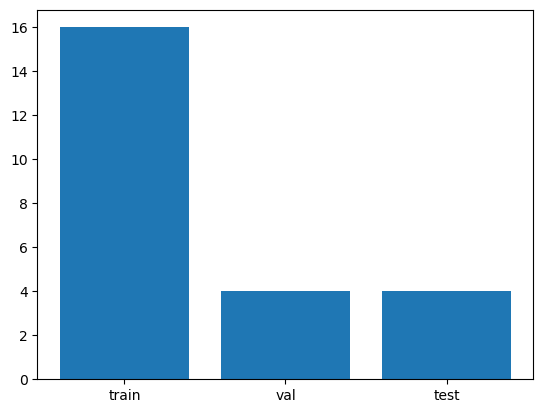

In [13]:
dataset_sizes = [len(train_set), len(val_set), len(test_set)]
labels = ['train', 'val', 'test']

plt.bar(labels, dataset_sizes)
plt.show()

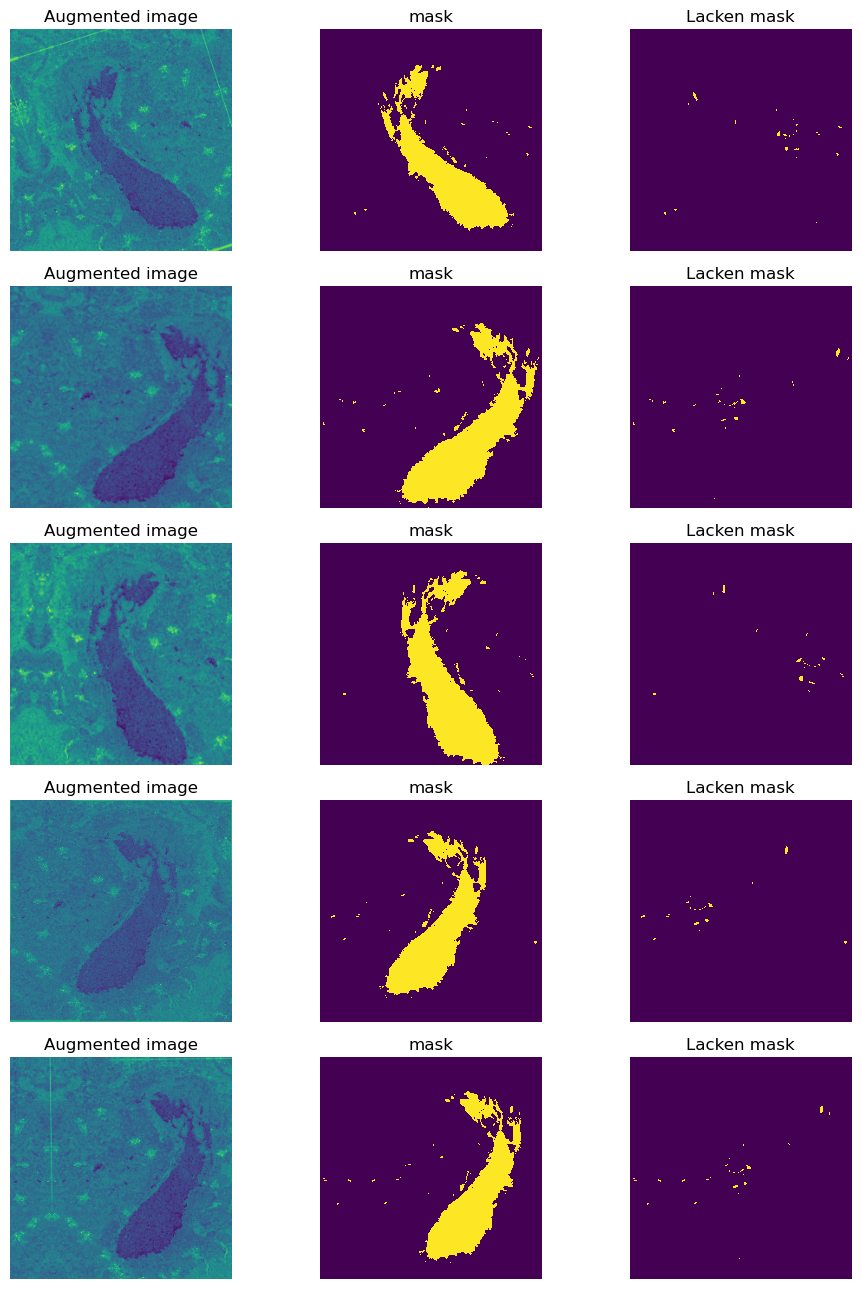

In [14]:
visualize_augmentations(train_set, idx=2, samples=5)


#### Train & Evaluate

In [ ]:
epochs = 50
model = UNetFT(1, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()
# criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([0.8], device=device))


In [ ]:
train_evaluate(model, epochs, valloader, valloader, optimizer, criterion, dict_file,
               model_file, best_dice=0)

  2%|▏         | 1/50 [00:01<01:04,  1.32s/it]

 
 Epoch: 1 
TRAIN FULL: Train Loss: 1.5639 | Train DICE Coeff: 0.2573  | Train IoU Coeff: 0.1481| | Train Bal Accuracy: 56.46 | Train Accuracy: 28.37 
TRAIN LACKENS: Train DICE Coeff: 0.0051  | Train IoU Coeff: 0.0026|  | Train Bal Accuracy: 52.14 |  Train Accuracy: 16.82 
VAL FULL: Val Loss: 1.5236 | Val DICE Coeff: 0.2164 | Val IoU Coeff: 0.1214 | Val Bal Accuracy: 50.00 | Val Accuracy: 12.14 
VAL LACKENS: Val DICE Coeff: 0.0047 | Val IoU Coeff: 0.0023 | Val Bal Accuracy: 50.00 |  Val Accuracy: 0.23| 


  4%|▍         | 2/50 [00:02<01:03,  1.32s/it]

 
 Epoch: 2 
TRAIN FULL: Train Loss: 1.5833 | Train DICE Coeff: 0.2338  | Train IoU Coeff: 0.1335| | Train Bal Accuracy: 55.48 | Train Accuracy: 27.34 
TRAIN LACKENS: Train DICE Coeff: 0.0047  | Train IoU Coeff: 0.0023|  | Train Bal Accuracy: 48.50 |  Train Accuracy: 17.19 
VAL FULL: Val Loss: 1.4772 | Val DICE Coeff: 0.2717 | Val IoU Coeff: 0.1574 | Val Bal Accuracy: 50.00 | Val Accuracy: 15.74 
VAL LACKENS: Val DICE Coeff: 0.0050 | Val IoU Coeff: 0.0025 | Val Bal Accuracy: 50.00 |  Val Accuracy: 0.25| 


  6%|▌         | 3/50 [00:03<01:00,  1.29s/it]

 
 Epoch: 3 
TRAIN FULL: Train Loss: 1.5509 | Train DICE Coeff: 0.2695  | Train IoU Coeff: 0.1557| | Train Bal Accuracy: 56.06 | Train Accuracy: 29.04 
TRAIN LACKENS: Train DICE Coeff: 0.0048  | Train IoU Coeff: 0.0024|  | Train Bal Accuracy: 53.04 |  Train Accuracy: 17.02 
VAL FULL: Val Loss: 1.5190 | Val DICE Coeff: 0.2233 | Val IoU Coeff: 0.1260 | Val Bal Accuracy: 50.00 | Val Accuracy: 12.60 
VAL LACKENS: Val DICE Coeff: 0.0049 | Val IoU Coeff: 0.0024 | Val Bal Accuracy: 50.00 |  Val Accuracy: 0.25| 


  8%|▊         | 4/50 [00:05<00:58,  1.27s/it]

 
 Epoch: 4 
TRAIN FULL: Train Loss: 1.5493 | Train DICE Coeff: 0.2656  | Train IoU Coeff: 0.1529| | Train Bal Accuracy: 55.50 | Train Accuracy: 29.12 
TRAIN LACKENS: Train DICE Coeff: 0.0049  | Train IoU Coeff: 0.0025|  | Train Bal Accuracy: 49.82 |  Train Accuracy: 17.60 
VAL FULL: Val Loss: 1.5298 | Val DICE Coeff: 0.2118 | Val IoU Coeff: 0.1185 | Val Bal Accuracy: 50.00 | Val Accuracy: 11.85 
VAL LACKENS: Val DICE Coeff: 0.0048 | Val IoU Coeff: 0.0024 | Val Bal Accuracy: 50.00 |  Val Accuracy: 0.24| 


 10%|█         | 5/50 [00:06<00:58,  1.29s/it]

 
 Epoch: 5 
TRAIN FULL: Train Loss: 1.5672 | Train DICE Coeff: 0.2501  | Train IoU Coeff: 0.1420| | Train Bal Accuracy: 54.13 | Train Accuracy: 28.00 
TRAIN LACKENS: Train DICE Coeff: 0.0052  | Train IoU Coeff: 0.0026|  | Train Bal Accuracy: 49.01 |  Train Accuracy: 17.62 
VAL FULL: Val Loss: 1.5166 | Val DICE Coeff: 0.2284 | Val IoU Coeff: 0.1292 | Val Bal Accuracy: 50.00 | Val Accuracy: 12.92 
VAL LACKENS: Val DICE Coeff: 0.0043 | Val IoU Coeff: 0.0022 | Val Bal Accuracy: 50.00 |  Val Accuracy: 0.22| 


 12%|█▏        | 6/50 [00:07<00:56,  1.28s/it]

 
 Epoch: 6 
TRAIN FULL: Train Loss: 1.5659 | Train DICE Coeff: 0.2515  | Train IoU Coeff: 0.1429| | Train Bal Accuracy: 53.66 | Train Accuracy: 26.48 
TRAIN LACKENS: Train DICE Coeff: 0.0050  | Train IoU Coeff: 0.0025|  | Train Bal Accuracy: 49.98 |  Train Accuracy: 15.63 
VAL FULL: Val Loss: 1.4931 | Val DICE Coeff: 0.2569 | Val IoU Coeff: 0.1478 | Val Bal Accuracy: 50.00 | Val Accuracy: 14.78 
VAL LACKENS: Val DICE Coeff: 0.0051 | Val IoU Coeff: 0.0025 | Val Bal Accuracy: 50.00 |  Val Accuracy: 0.26| 


 14%|█▍        | 7/50 [00:08<00:54,  1.27s/it]

 
 Epoch: 7 
TRAIN FULL: Train Loss: 1.5249 | Train DICE Coeff: 0.2890  | Train IoU Coeff: 0.1692| | Train Bal Accuracy: 54.68 | Train Accuracy: 29.24 
TRAIN LACKENS: Train DICE Coeff: 0.0054  | Train IoU Coeff: 0.0027|  | Train Bal Accuracy: 49.39 |  Train Accuracy: 16.31 
VAL FULL: Val Loss: 1.5117 | Val DICE Coeff: 0.2363 | Val IoU Coeff: 0.1345 | Val Bal Accuracy: 50.02 | Val Accuracy: 13.48 
VAL LACKENS: Val DICE Coeff: 0.0049 | Val IoU Coeff: 0.0024 | Val Bal Accuracy: 50.01 |  Val Accuracy: 0.28| 


 16%|█▌        | 8/50 [00:10<00:55,  1.33s/it]

 
 Epoch: 8 
TRAIN FULL: Train Loss: 1.5501 | Train DICE Coeff: 0.2695  | Train IoU Coeff: 0.1552| | Train Bal Accuracy: 54.67 | Train Accuracy: 28.57 
TRAIN LACKENS: Train DICE Coeff: 0.0060  | Train IoU Coeff: 0.0031|  | Train Bal Accuracy: 51.97 |  Train Accuracy: 16.92 
VAL FULL: Val Loss: 1.5340 | Val DICE Coeff: 0.2011 | Val IoU Coeff: 0.1121 | Val Bal Accuracy: 49.57 | Val Accuracy: 26.86 
VAL LACKENS: Val DICE Coeff: 0.0045 | Val IoU Coeff: 0.0022 | Val Bal Accuracy: 49.05 |  Val Accuracy: 20.35| 


 18%|█▊        | 9/50 [00:11<00:54,  1.34s/it]

 
 Epoch: 9 
TRAIN FULL: Train Loss: 1.5644 | Train DICE Coeff: 0.2559  | Train IoU Coeff: 0.1476| | Train Bal Accuracy: 55.86 | Train Accuracy: 27.79 
TRAIN LACKENS: Train DICE Coeff: 0.0050  | Train IoU Coeff: 0.0025|  | Train Bal Accuracy: 52.51 |  Train Accuracy: 16.26 
VAL FULL: Val Loss: 1.5367 | Val DICE Coeff: 0.2001 | Val IoU Coeff: 0.1119 | Val Bal Accuracy: 49.84 | Val Accuracy: 29.76 
VAL LACKENS: Val DICE Coeff: 0.0044 | Val IoU Coeff: 0.0022 | Val Bal Accuracy: 49.50 |  Val Accuracy: 23.92| 


 20%|██        | 10/50 [00:13<00:53,  1.33s/it]

 
 Epoch: 10 
TRAIN FULL: Train Loss: 1.5798 | Train DICE Coeff: 0.2405  | Train IoU Coeff: 0.1357| | Train Bal Accuracy: 55.42 | Train Accuracy: 27.32 
TRAIN LACKENS: Train DICE Coeff: 0.0050  | Train IoU Coeff: 0.0025|  | Train Bal Accuracy: 51.01 |  Train Accuracy: 16.98 
VAL FULL: Val Loss: 1.5186 | Val DICE Coeff: 0.2202 | Val IoU Coeff: 0.1241 | Val Bal Accuracy: 49.97 | Val Accuracy: 30.45 
VAL LACKENS: Val DICE Coeff: 0.0049 | Val IoU Coeff: 0.0024 | Val Bal Accuracy: 49.46 |  Val Accuracy: 23.97| 


 22%|██▏       | 11/50 [00:14<00:51,  1.33s/it]

 
 Epoch: 11 
TRAIN FULL: Train Loss: 1.5289 | Train DICE Coeff: 0.2802  | Train IoU Coeff: 0.1630| | Train Bal Accuracy: 54.42 | Train Accuracy: 29.46 
TRAIN LACKENS: Train DICE Coeff: 0.0047  | Train IoU Coeff: 0.0023|  | Train Bal Accuracy: 47.96 |  Train Accuracy: 17.34 
VAL FULL: Val Loss: 1.5022 | Val DICE Coeff: 0.2397 | Val IoU Coeff: 0.1371 | Val Bal Accuracy: 48.83 | Val Accuracy: 31.27 
VAL LACKENS: Val DICE Coeff: 0.0058 | Val IoU Coeff: 0.0029 | Val Bal Accuracy: 49.62 |  Val Accuracy: 24.05| 


 24%|██▍       | 12/50 [00:15<00:49,  1.30s/it]

 
 Epoch: 12 
TRAIN FULL: Train Loss: 1.5426 | Train DICE Coeff: 0.2779  | Train IoU Coeff: 0.1630| | Train Bal Accuracy: 56.31 | Train Accuracy: 28.84 
TRAIN LACKENS: Train DICE Coeff: 0.0048  | Train IoU Coeff: 0.0024|  | Train Bal Accuracy: 52.01 |  Train Accuracy: 15.88 
VAL FULL: Val Loss: 1.5269 | Val DICE Coeff: 0.2152 | Val IoU Coeff: 0.1211 | Val Bal Accuracy: 49.50 | Val Accuracy: 30.46 
VAL LACKENS: Val DICE Coeff: 0.0040 | Val IoU Coeff: 0.0020 | Val Bal Accuracy: 49.66 |  Val Accuracy: 24.11| 


 26%|██▌       | 13/50 [00:16<00:47,  1.28s/it]

 
 Epoch: 13 
TRAIN FULL: Train Loss: 1.5568 | Train DICE Coeff: 0.2569  | Train IoU Coeff: 0.1460| | Train Bal Accuracy: 53.94 | Train Accuracy: 28.06 
TRAIN LACKENS: Train DICE Coeff: 0.0051  | Train IoU Coeff: 0.0025|  | Train Bal Accuracy: 49.04 |  Train Accuracy: 17.35 
VAL FULL: Val Loss: 1.4991 | Val DICE Coeff: 0.2459 | Val IoU Coeff: 0.1404 | Val Bal Accuracy: 49.50 | Val Accuracy: 31.56 
VAL LACKENS: Val DICE Coeff: 0.0048 | Val IoU Coeff: 0.0024 | Val Bal Accuracy: 49.64 |  Val Accuracy: 24.15| 


 28%|██▊       | 14/50 [00:18<00:45,  1.27s/it]

 
 Epoch: 14 
TRAIN FULL: Train Loss: 1.5474 | Train DICE Coeff: 0.2737  | Train IoU Coeff: 0.1600| | Train Bal Accuracy: 55.54 | Train Accuracy: 27.71 
TRAIN LACKENS: Train DICE Coeff: 0.0056  | Train IoU Coeff: 0.0029|  | Train Bal Accuracy: 52.36 |  Train Accuracy: 14.91 
VAL FULL: Val Loss: 1.5088 | Val DICE Coeff: 0.2371 | Val IoU Coeff: 0.1348 | Val Bal Accuracy: 50.26 | Val Accuracy: 31.32 
VAL LACKENS: Val DICE Coeff: 0.0052 | Val IoU Coeff: 0.0026 | Val Bal Accuracy: 49.65 |  Val Accuracy: 24.27| 


 30%|███       | 15/50 [00:19<00:44,  1.27s/it]

 
 Epoch: 15 
TRAIN FULL: Train Loss: 1.5515 | Train DICE Coeff: 0.2617  | Train IoU Coeff: 0.1529| | Train Bal Accuracy: 55.02 | Train Accuracy: 28.16 
TRAIN LACKENS: Train DICE Coeff: 0.0053  | Train IoU Coeff: 0.0027|  | Train Bal Accuracy: 50.00 |  Train Accuracy: 16.44 
VAL FULL: Val Loss: 1.5259 | Val DICE Coeff: 0.2211 | Val IoU Coeff: 0.1243 | Val Bal Accuracy: 49.11 | Val Accuracy: 30.83 
VAL LACKENS: Val DICE Coeff: 0.0045 | Val IoU Coeff: 0.0022 | Val Bal Accuracy: 49.77 |  Val Accuracy: 24.33| 


 32%|███▏      | 16/50 [00:20<00:43,  1.28s/it]

 
 Epoch: 16 
TRAIN FULL: Train Loss: 1.5637 | Train DICE Coeff: 0.2582  | Train IoU Coeff: 0.1479| | Train Bal Accuracy: 55.90 | Train Accuracy: 27.85 
TRAIN LACKENS: Train DICE Coeff: 0.0050  | Train IoU Coeff: 0.0026|  | Train Bal Accuracy: 51.15 |  Train Accuracy: 16.30 
VAL FULL: Val Loss: 1.5201 | Val DICE Coeff: 0.2283 | Val IoU Coeff: 0.1290 | Val Bal Accuracy: 49.84 | Val Accuracy: 31.09 
VAL LACKENS: Val DICE Coeff: 0.0045 | Val IoU Coeff: 0.0022 | Val Bal Accuracy: 49.76 |  Val Accuracy: 24.34| 


 34%|███▍      | 17/50 [00:21<00:41,  1.27s/it]

 
 Epoch: 17 
TRAIN FULL: Train Loss: 1.5444 | Train DICE Coeff: 0.2691  | Train IoU Coeff: 0.1562| | Train Bal Accuracy: 55.49 | Train Accuracy: 29.46 
TRAIN LACKENS: Train DICE Coeff: 0.0046  | Train IoU Coeff: 0.0023|  | Train Bal Accuracy: 47.90 |  Train Accuracy: 17.70 
VAL FULL: Val Loss: 1.5382 | Val DICE Coeff: 0.2117 | Val IoU Coeff: 0.1188 | Val Bal Accuracy: 50.95 | Val Accuracy: 30.62 
VAL LACKENS: Val DICE Coeff: 0.0047 | Val IoU Coeff: 0.0023 | Val Bal Accuracy: 49.88 |  Val Accuracy: 24.42| 


 36%|███▌      | 18/50 [00:23<00:41,  1.29s/it]

 
 Epoch: 18 
TRAIN FULL: Train Loss: 1.5744 | Train DICE Coeff: 0.2402  | Train IoU Coeff: 0.1368| | Train Bal Accuracy: 55.14 | Train Accuracy: 28.09 
TRAIN LACKENS: Train DICE Coeff: 0.0047  | Train IoU Coeff: 0.0024|  | Train Bal Accuracy: 49.36 |  Train Accuracy: 17.95 
VAL FULL: Val Loss: 1.5255 | Val DICE Coeff: 0.2260 | Val IoU Coeff: 0.1276 | Val Bal Accuracy: 49.68 | Val Accuracy: 31.12 
VAL LACKENS: Val DICE Coeff: 0.0053 | Val IoU Coeff: 0.0027 | Val Bal Accuracy: 49.79 |  Val Accuracy: 24.49| 


 38%|███▊      | 19/50 [00:24<00:39,  1.28s/it]

 
 Epoch: 19 
TRAIN FULL: Train Loss: 1.5700 | Train DICE Coeff: 0.2381  | Train IoU Coeff: 0.1362| | Train Bal Accuracy: 52.92 | Train Accuracy: 26.20 
TRAIN LACKENS: Train DICE Coeff: 0.0064  | Train IoU Coeff: 0.0033|  | Train Bal Accuracy: 49.11 |  Train Accuracy: 16.20 
VAL FULL: Val Loss: 1.4985 | Val DICE Coeff: 0.2552 | Val IoU Coeff: 0.1464 | Val Bal Accuracy: 49.78 | Val Accuracy: 32.23 
VAL LACKENS: Val DICE Coeff: 0.0056 | Val IoU Coeff: 0.0028 | Val Bal Accuracy: 49.80 |  Val Accuracy: 24.57| 


 40%|████      | 20/50 [00:25<00:38,  1.27s/it]

 
 Epoch: 20 
TRAIN FULL: Train Loss: 1.5819 | Train DICE Coeff: 0.2300  | Train IoU Coeff: 0.1310| | Train Bal Accuracy: 54.16 | Train Accuracy: 26.80 
TRAIN LACKENS: Train DICE Coeff: 0.0043  | Train IoU Coeff: 0.0021|  | Train Bal Accuracy: 49.38 |  Train Accuracy: 17.08 
VAL FULL: Val Loss: 1.5306 | Val DICE Coeff: 0.2232 | Val IoU Coeff: 0.1257 | Val Bal Accuracy: 50.15 | Val Accuracy: 31.12 
VAL LACKENS: Val DICE Coeff: 0.0042 | Val IoU Coeff: 0.0021 | Val Bal Accuracy: 49.84 |  Val Accuracy: 24.58| 


 42%|████▏     | 21/50 [00:27<00:36,  1.26s/it]

 
 Epoch: 21 
TRAIN FULL: Train Loss: 1.5737 | Train DICE Coeff: 0.2431  | Train IoU Coeff: 0.1373| | Train Bal Accuracy: 54.79 | Train Accuracy: 27.36 
TRAIN LACKENS: Train DICE Coeff: 0.0046  | Train IoU Coeff: 0.0023|  | Train Bal Accuracy: 49.78 |  Train Accuracy: 17.02 
VAL FULL: Val Loss: 1.5511 | Val DICE Coeff: 0.2032 | Val IoU Coeff: 0.1132 | Val Bal Accuracy: 49.73 | Val Accuracy: 30.43 
VAL LACKENS: Val DICE Coeff: 0.0047 | Val IoU Coeff: 0.0023 | Val Bal Accuracy: 49.74 |  Val Accuracy: 24.62| 


 44%|████▍     | 22/50 [00:28<00:35,  1.26s/it]

 
 Epoch: 22 
TRAIN FULL: Train Loss: 1.5689 | Train DICE Coeff: 0.2516  | Train IoU Coeff: 0.1425| | Train Bal Accuracy: 54.84 | Train Accuracy: 27.08 
TRAIN LACKENS: Train DICE Coeff: 0.0048  | Train IoU Coeff: 0.0024|  | Train Bal Accuracy: 52.03 |  Train Accuracy: 16.13 
VAL FULL: Val Loss: 1.5186 | Val DICE Coeff: 0.2378 | Val IoU Coeff: 0.1352 | Val Bal Accuracy: 49.97 | Val Accuracy: 31.66 
VAL LACKENS: Val DICE Coeff: 0.0053 | Val IoU Coeff: 0.0026 | Val Bal Accuracy: 49.81 |  Val Accuracy: 24.65| 


 46%|████▌     | 23/50 [00:29<00:34,  1.27s/it]

 
 Epoch: 23 
TRAIN FULL: Train Loss: 1.5611 | Train DICE Coeff: 0.2509  | Train IoU Coeff: 0.1448| | Train Bal Accuracy: 54.66 | Train Accuracy: 28.17 
TRAIN LACKENS: Train DICE Coeff: 0.0047  | Train IoU Coeff: 0.0024|  | Train Bal Accuracy: 48.90 |  Train Accuracy: 17.40 
VAL FULL: Val Loss: 1.5460 | Val DICE Coeff: 0.2110 | Val IoU Coeff: 0.1180 | Val Bal Accuracy: 49.83 | Val Accuracy: 30.85 
VAL LACKENS: Val DICE Coeff: 0.0045 | Val IoU Coeff: 0.0023 | Val Bal Accuracy: 49.98 |  Val Accuracy: 24.73| 


 48%|████▊     | 24/50 [00:30<00:33,  1.28s/it]

 
 Epoch: 24 
TRAIN FULL: Train Loss: 1.5626 | Train DICE Coeff: 0.2506  | Train IoU Coeff: 0.1428| | Train Bal Accuracy: 54.23 | Train Accuracy: 27.69 
TRAIN LACKENS: Train DICE Coeff: 0.0051  | Train IoU Coeff: 0.0026|  | Train Bal Accuracy: 48.04 |  Train Accuracy: 17.07 
VAL FULL: Val Loss: 1.5012 | Val DICE Coeff: 0.2580 | Val IoU Coeff: 0.1484 | Val Bal Accuracy: 49.75 | Val Accuracy: 32.58 
VAL LACKENS: Val DICE Coeff: 0.0059 | Val IoU Coeff: 0.0029 | Val Bal Accuracy: 49.91 |  Val Accuracy: 24.86| 


 50%|█████     | 25/50 [00:32<00:32,  1.28s/it]

 
 Epoch: 25 
TRAIN FULL: Train Loss: 1.5545 | Train DICE Coeff: 0.2614  | Train IoU Coeff: 0.1502| | Train Bal Accuracy: 54.64 | Train Accuracy: 28.83 
TRAIN LACKENS: Train DICE Coeff: 0.0053  | Train IoU Coeff: 0.0026|  | Train Bal Accuracy: 47.51 |  Train Accuracy: 17.73 
VAL FULL: Val Loss: 1.5255 | Val DICE Coeff: 0.2354 | Val IoU Coeff: 0.1337 | Val Bal Accuracy: 50.61 | Val Accuracy: 32.26 
VAL LACKENS: Val DICE Coeff: 0.0046 | Val IoU Coeff: 0.0023 | Val Bal Accuracy: 50.31 |  Val Accuracy: 25.35| 


 52%|█████▏    | 26/50 [00:33<00:30,  1.27s/it]

 
 Epoch: 26 
TRAIN FULL: Train Loss: 1.5703 | Train DICE Coeff: 0.2496  | Train IoU Coeff: 0.1437| | Train Bal Accuracy: 55.59 | Train Accuracy: 27.41 
TRAIN LACKENS: Train DICE Coeff: 0.0042  | Train IoU Coeff: 0.0021|  | Train Bal Accuracy: 51.62 |  Train Accuracy: 16.19 
VAL FULL: Val Loss: 1.5387 | Val DICE Coeff: 0.2249 | Val IoU Coeff: 0.1267 | Val Bal Accuracy: 50.85 | Val Accuracy: 32.51 
VAL LACKENS: Val DICE Coeff: 0.0049 | Val IoU Coeff: 0.0024 | Val Bal Accuracy: 50.68 |  Val Accuracy: 26.06| 


 54%|█████▍    | 27/50 [00:34<00:29,  1.27s/it]

 
 Epoch: 27 
TRAIN FULL: Train Loss: 1.5522 | Train DICE Coeff: 0.2685  | Train IoU Coeff: 0.1539| | Train Bal Accuracy: 55.86 | Train Accuracy: 28.60 
TRAIN LACKENS: Train DICE Coeff: 0.0047  | Train IoU Coeff: 0.0024|  | Train Bal Accuracy: 51.10 |  Train Accuracy: 16.67 
VAL FULL: Val Loss: 1.5646 | Val DICE Coeff: 0.1994 | Val IoU Coeff: 0.1107 | Val Bal Accuracy: 49.60 | Val Accuracy: 31.58 
VAL LACKENS: Val DICE Coeff: 0.0044 | Val IoU Coeff: 0.0022 | Val Bal Accuracy: 50.58 |  Val Accuracy: 25.98| 


 56%|█████▌    | 28/50 [00:36<00:28,  1.30s/it]

 
 Epoch: 28 
TRAIN FULL: Train Loss: 1.5438 | Train DICE Coeff: 0.2695  | Train IoU Coeff: 0.1555| | Train Bal Accuracy: 54.56 | Train Accuracy: 28.86 
TRAIN LACKENS: Train DICE Coeff: 0.0051  | Train IoU Coeff: 0.0026|  | Train Bal Accuracy: 48.87 |  Train Accuracy: 17.27 
VAL FULL: Val Loss: 1.5620 | Val DICE Coeff: 0.2062 | Val IoU Coeff: 0.1147 | Val Bal Accuracy: 49.38 | Val Accuracy: 32.87 
VAL LACKENS: Val DICE Coeff: 0.0045 | Val IoU Coeff: 0.0022 | Val Bal Accuracy: 51.15 |  Val Accuracy: 27.17| 


 58%|█████▊    | 29/50 [00:37<00:27,  1.31s/it]

 
 Epoch: 29 
TRAIN FULL: Train Loss: 1.5520 | Train DICE Coeff: 0.2653  | Train IoU Coeff: 0.1534| | Train Bal Accuracy: 55.40 | Train Accuracy: 28.59 
TRAIN LACKENS: Train DICE Coeff: 0.0048  | Train IoU Coeff: 0.0024|  | Train Bal Accuracy: 50.29 |  Train Accuracy: 16.85 
VAL FULL: Val Loss: 1.4959 | Val DICE Coeff: 0.2749 | Val IoU Coeff: 0.1609 | Val Bal Accuracy: 50.82 | Val Accuracy: 36.18 
VAL LACKENS: Val DICE Coeff: 0.0043 | Val IoU Coeff: 0.0021 | Val Bal Accuracy: 51.99 |  Val Accuracy: 28.03| 


 60%|██████    | 30/50 [00:38<00:25,  1.30s/it]

 
 Epoch: 30 
TRAIN FULL: Train Loss: 1.5437 | Train DICE Coeff: 0.2684  | Train IoU Coeff: 0.1551| | Train Bal Accuracy: 54.84 | Train Accuracy: 28.84 
TRAIN LACKENS: Train DICE Coeff: 0.0053  | Train IoU Coeff: 0.0027|  | Train Bal Accuracy: 49.73 |  Train Accuracy: 17.21 
VAL FULL: Val Loss: 1.5422 | Val DICE Coeff: 0.2307 | Val IoU Coeff: 0.1308 | Val Bal Accuracy: 51.20 | Val Accuracy: 35.03 
VAL LACKENS: Val DICE Coeff: 0.0055 | Val IoU Coeff: 0.0027 | Val Bal Accuracy: 52.13 |  Val Accuracy: 28.60| 


 62%|██████▏   | 31/50 [00:39<00:24,  1.28s/it]

 
 Epoch: 31 
TRAIN FULL: Train Loss: 1.6033 | Train DICE Coeff: 0.2124  | Train IoU Coeff: 0.1190| | Train Bal Accuracy: 55.20 | Train Accuracy: 25.80 
TRAIN LACKENS: Train DICE Coeff: 0.0044  | Train IoU Coeff: 0.0022|  | Train Bal Accuracy: 50.26 |  Train Accuracy: 16.71 
VAL FULL: Val Loss: 1.5431 | Val DICE Coeff: 0.2337 | Val IoU Coeff: 0.1315 | Val Bal Accuracy: 50.37 | Val Accuracy: 36.27 
VAL LACKENS: Val DICE Coeff: 0.0045 | Val IoU Coeff: 0.0023 | Val Bal Accuracy: 52.69 |  Val Accuracy: 29.97| 


 64%|██████▍   | 32/50 [00:41<00:22,  1.27s/it]

 
 Epoch: 32 
TRAIN FULL: Train Loss: 1.5752 | Train DICE Coeff: 0.2424  | Train IoU Coeff: 0.1374| | Train Bal Accuracy: 55.49 | Train Accuracy: 27.31 
TRAIN LACKENS: Train DICE Coeff: 0.0050  | Train IoU Coeff: 0.0025|  | Train Bal Accuracy: 50.96 |  Train Accuracy: 16.78 
VAL FULL: Val Loss: 1.5428 | Val DICE Coeff: 0.2353 | Val IoU Coeff: 0.1333 | Val Bal Accuracy: 50.35 | Val Accuracy: 37.14 
VAL LACKENS: Val DICE Coeff: 0.0050 | Val IoU Coeff: 0.0025 | Val Bal Accuracy: 53.08 |  Val Accuracy: 30.85| 


 66%|██████▌   | 33/50 [00:42<00:21,  1.27s/it]

 
 Epoch: 33 
TRAIN FULL: Train Loss: 1.5796 | Train DICE Coeff: 0.2416  | Train IoU Coeff: 0.1384| | Train Bal Accuracy: 56.70 | Train Accuracy: 27.47 
TRAIN LACKENS: Train DICE Coeff: 0.0043  | Train IoU Coeff: 0.0022|  | Train Bal Accuracy: 52.21 |  Train Accuracy: 16.54 
VAL FULL: Val Loss: 1.5468 | Val DICE Coeff: 0.2360 | Val IoU Coeff: 0.1329 | Val Bal Accuracy: 51.60 | Val Accuracy: 37.62 
VAL LACKENS: Val DICE Coeff: 0.0046 | Val IoU Coeff: 0.0023 | Val Bal Accuracy: 53.69 |  Val Accuracy: 31.31| 


 68%|██████▊   | 34/50 [00:43<00:20,  1.26s/it]

 
 Epoch: 34 
TRAIN FULL: Train Loss: 1.5374 | Train DICE Coeff: 0.2749  | Train IoU Coeff: 0.1599| | Train Bal Accuracy: 54.88 | Train Accuracy: 29.25 
TRAIN LACKENS: Train DICE Coeff: 0.0043  | Train IoU Coeff: 0.0022|  | Train Bal Accuracy: 47.08 |  Train Accuracy: 17.21 
VAL FULL: Val Loss: 1.5218 | Val DICE Coeff: 0.2621 | Val IoU Coeff: 0.1498 | Val Bal Accuracy: 51.42 | Val Accuracy: 38.67 
VAL LACKENS: Val DICE Coeff: 0.0054 | Val IoU Coeff: 0.0027 | Val Bal Accuracy: 53.58 |  Val Accuracy: 31.66| 


 70%|███████   | 35/50 [00:44<00:18,  1.26s/it]

 
 Epoch: 35 
TRAIN FULL: Train Loss: 1.5641 | Train DICE Coeff: 0.2542  | Train IoU Coeff: 0.1454| | Train Bal Accuracy: 55.19 | Train Accuracy: 28.35 
TRAIN LACKENS: Train DICE Coeff: 0.0055  | Train IoU Coeff: 0.0027|  | Train Bal Accuracy: 50.49 |  Train Accuracy: 17.44 
VAL FULL: Val Loss: 1.5662 | Val DICE Coeff: 0.2217 | Val IoU Coeff: 0.1233 | Val Bal Accuracy: 51.50 | Val Accuracy: 38.76 
VAL LACKENS: Val DICE Coeff: 0.0048 | Val IoU Coeff: 0.0024 | Val Bal Accuracy: 54.32 |  Val Accuracy: 33.18| 


 72%|███████▏  | 36/50 [00:46<00:17,  1.25s/it]

 
 Epoch: 36 
TRAIN FULL: Train Loss: 1.5962 | Train DICE Coeff: 0.2207  | Train IoU Coeff: 0.1244| | Train Bal Accuracy: 54.03 | Train Accuracy: 25.19 
TRAIN LACKENS: Train DICE Coeff: 0.0052  | Train IoU Coeff: 0.0027|  | Train Bal Accuracy: 51.87 |  Train Accuracy: 15.73 
VAL FULL: Val Loss: 1.5446 | Val DICE Coeff: 0.2424 | Val IoU Coeff: 0.1365 | Val Bal Accuracy: 51.85 | Val Accuracy: 39.34 
VAL LACKENS: Val DICE Coeff: 0.0044 | Val IoU Coeff: 0.0022 | Val Bal Accuracy: 54.57 |  Val Accuracy: 33.03| 


 74%|███████▍  | 37/50 [00:47<00:16,  1.27s/it]

 
 Epoch: 37 
TRAIN FULL: Train Loss: 1.5698 | Train DICE Coeff: 0.2454  | Train IoU Coeff: 0.1428| | Train Bal Accuracy: 55.52 | Train Accuracy: 27.52 
TRAIN LACKENS: Train DICE Coeff: 0.0047  | Train IoU Coeff: 0.0023|  | Train Bal Accuracy: 50.60 |  Train Accuracy: 16.47 
VAL FULL: Val Loss: 1.5479 | Val DICE Coeff: 0.2398 | Val IoU Coeff: 0.1353 | Val Bal Accuracy: 51.08 | Val Accuracy: 39.66 
VAL LACKENS: Val DICE Coeff: 0.0051 | Val IoU Coeff: 0.0025 | Val Bal Accuracy: 54.08 |  Val Accuracy: 33.71| 


 76%|███████▌  | 38/50 [00:48<00:15,  1.29s/it]

 
 Epoch: 38 
TRAIN FULL: Train Loss: 1.5510 | Train DICE Coeff: 0.2627  | Train IoU Coeff: 0.1509| | Train Bal Accuracy: 54.86 | Train Accuracy: 28.68 
TRAIN LACKENS: Train DICE Coeff: 0.0055  | Train IoU Coeff: 0.0028|  | Train Bal Accuracy: 49.83 |  Train Accuracy: 17.43 
VAL FULL: Val Loss: 1.5708 | Val DICE Coeff: 0.2184 | Val IoU Coeff: 0.1217 | Val Bal Accuracy: 52.40 | Val Accuracy: 39.65 
VAL LACKENS: Val DICE Coeff: 0.0060 | Val IoU Coeff: 0.0030 | Val Bal Accuracy: 54.79 |  Val Accuracy: 34.29| 


 78%|███████▊  | 39/50 [00:50<00:14,  1.29s/it]

 
 Epoch: 39 
TRAIN FULL: Train Loss: 1.5718 | Train DICE Coeff: 0.2455  | Train IoU Coeff: 0.1405| | Train Bal Accuracy: 55.50 | Train Accuracy: 27.21 
TRAIN LACKENS: Train DICE Coeff: 0.0047  | Train IoU Coeff: 0.0023|  | Train Bal Accuracy: 52.00 |  Train Accuracy: 16.31 
VAL FULL: Val Loss: 1.5431 | Val DICE Coeff: 0.2399 | Val IoU Coeff: 0.1378 | Val Bal Accuracy: 50.66 | Val Accuracy: 39.42 
VAL LACKENS: Val DICE Coeff: 0.0049 | Val IoU Coeff: 0.0025 | Val Bal Accuracy: 54.14 |  Val Accuracy: 33.21| 


 80%|████████  | 40/50 [00:51<00:13,  1.31s/it]

 
 Epoch: 40 
TRAIN FULL: Train Loss: 1.5729 | Train DICE Coeff: 0.2423  | Train IoU Coeff: 0.1411| | Train Bal Accuracy: 56.32 | Train Accuracy: 28.24 
TRAIN LACKENS: Train DICE Coeff: 0.0041  | Train IoU Coeff: 0.0021|  | Train Bal Accuracy: 49.33 |  Train Accuracy: 17.35 
VAL FULL: Val Loss: 1.5082 | Val DICE Coeff: 0.2802 | Val IoU Coeff: 0.1616 | Val Bal Accuracy: 50.57 | Val Accuracy: 40.35 
VAL LACKENS: Val DICE Coeff: 0.0054 | Val IoU Coeff: 0.0027 | Val Bal Accuracy: 53.92 |  Val Accuracy: 33.07| 


 82%|████████▏ | 41/50 [00:52<00:11,  1.30s/it]

 
 Epoch: 41 
TRAIN FULL: Train Loss: 1.5513 | Train DICE Coeff: 0.2630  | Train IoU Coeff: 0.1533| | Train Bal Accuracy: 55.69 | Train Accuracy: 28.86 
TRAIN LACKENS: Train DICE Coeff: 0.0043  | Train IoU Coeff: 0.0022|  | Train Bal Accuracy: 49.60 |  Train Accuracy: 17.11 
VAL FULL: Val Loss: 1.5249 | Val DICE Coeff: 0.2619 | Val IoU Coeff: 0.1519 | Val Bal Accuracy: 50.53 | Val Accuracy: 40.00 
VAL LACKENS: Val DICE Coeff: 0.0052 | Val IoU Coeff: 0.0025 | Val Bal Accuracy: 54.17 |  Val Accuracy: 33.10| 


 84%|████████▍ | 42/50 [00:53<00:10,  1.28s/it]

 
 Epoch: 42 
TRAIN FULL: Train Loss: 1.5352 | Train DICE Coeff: 0.2831  | Train IoU Coeff: 0.1656| | Train Bal Accuracy: 55.13 | Train Accuracy: 29.37 
TRAIN LACKENS: Train DICE Coeff: 0.0056  | Train IoU Coeff: 0.0028|  | Train Bal Accuracy: 49.62 |  Train Accuracy: 16.72 
VAL FULL: Val Loss: 1.5474 | Val DICE Coeff: 0.2377 | Val IoU Coeff: 0.1347 | Val Bal Accuracy: 50.32 | Val Accuracy: 39.07 
VAL LACKENS: Val DICE Coeff: 0.0045 | Val IoU Coeff: 0.0022 | Val Bal Accuracy: 53.59 |  Val Accuracy: 33.14| 


 86%|████████▌ | 43/50 [00:55<00:08,  1.27s/it]

 
 Epoch: 43 
TRAIN FULL: Train Loss: 1.5691 | Train DICE Coeff: 0.2425  | Train IoU Coeff: 0.1384| | Train Bal Accuracy: 54.12 | Train Accuracy: 27.43 
TRAIN LACKENS: Train DICE Coeff: 0.0056  | Train IoU Coeff: 0.0028|  | Train Bal Accuracy: 47.19 |  Train Accuracy: 17.21 
VAL FULL: Val Loss: 1.5537 | Val DICE Coeff: 0.2376 | Val IoU Coeff: 0.1344 | Val Bal Accuracy: 49.21 | Val Accuracy: 40.67 
VAL LACKENS: Val DICE Coeff: 0.0049 | Val IoU Coeff: 0.0024 | Val Bal Accuracy: 54.59 |  Val Accuracy: 34.90| 


 88%|████████▊ | 44/50 [00:56<00:07,  1.26s/it]

 
 Epoch: 44 
TRAIN FULL: Train Loss: 1.5644 | Train DICE Coeff: 0.2597  | Train IoU Coeff: 0.1487| | Train Bal Accuracy: 55.60 | Train Accuracy: 28.29 
TRAIN LACKENS: Train DICE Coeff: 0.0055  | Train IoU Coeff: 0.0027|  | Train Bal Accuracy: 52.63 |  Train Accuracy: 16.91 
VAL FULL: Val Loss: 1.5549 | Val DICE Coeff: 0.2334 | Val IoU Coeff: 0.1322 | Val Bal Accuracy: 51.13 | Val Accuracy: 39.82 
VAL LACKENS: Val DICE Coeff: 0.0050 | Val IoU Coeff: 0.0025 | Val Bal Accuracy: 54.59 |  Val Accuracy: 33.92| 


 90%|█████████ | 45/50 [00:57<00:06,  1.27s/it]

 
 Epoch: 45 
TRAIN FULL: Train Loss: 1.5682 | Train DICE Coeff: 0.2428  | Train IoU Coeff: 0.1399| | Train Bal Accuracy: 54.01 | Train Accuracy: 26.88 
TRAIN LACKENS: Train DICE Coeff: 0.0047  | Train IoU Coeff: 0.0024|  | Train Bal Accuracy: 50.00 |  Train Accuracy: 16.35 
VAL FULL: Val Loss: 1.5617 | Val DICE Coeff: 0.2279 | Val IoU Coeff: 0.1272 | Val Bal Accuracy: 49.48 | Val Accuracy: 39.60 
VAL LACKENS: Val DICE Coeff: 0.0047 | Val IoU Coeff: 0.0023 | Val Bal Accuracy: 54.35 |  Val Accuracy: 34.00| 


 92%|█████████▏| 46/50 [00:58<00:05,  1.26s/it]

 
 Epoch: 46 
TRAIN FULL: Train Loss: 1.5778 | Train DICE Coeff: 0.2411  | Train IoU Coeff: 0.1357| | Train Bal Accuracy: 54.91 | Train Accuracy: 26.92 
TRAIN LACKENS: Train DICE Coeff: 0.0048  | Train IoU Coeff: 0.0024|  | Train Bal Accuracy: 50.99 |  Train Accuracy: 16.59 
VAL FULL: Val Loss: 1.5504 | Val DICE Coeff: 0.2427 | Val IoU Coeff: 0.1386 | Val Bal Accuracy: 50.79 | Val Accuracy: 41.68 
VAL LACKENS: Val DICE Coeff: 0.0048 | Val IoU Coeff: 0.0024 | Val Bal Accuracy: 54.98 |  Val Accuracy: 35.86| 


 94%|█████████▍| 47/50 [01:00<00:03,  1.28s/it]

 
 Epoch: 47 
TRAIN FULL: Train Loss: 1.5302 | Train DICE Coeff: 0.2827  | Train IoU Coeff: 0.1684| | Train Bal Accuracy: 56.06 | Train Accuracy: 30.24 
TRAIN LACKENS: Train DICE Coeff: 0.0057  | Train IoU Coeff: 0.0029|  | Train Bal Accuracy: 51.02 |  Train Accuracy: 17.37 
VAL FULL: Val Loss: 1.5484 | Val DICE Coeff: 0.2405 | Val IoU Coeff: 0.1356 | Val Bal Accuracy: 50.61 | Val Accuracy: 39.82 
VAL LACKENS: Val DICE Coeff: 0.0049 | Val IoU Coeff: 0.0024 | Val Bal Accuracy: 53.71 |  Val Accuracy: 34.04| 


 96%|█████████▌| 48/50 [01:01<00:02,  1.30s/it]

 
 Epoch: 48 
TRAIN FULL: Train Loss: 1.5931 | Train DICE Coeff: 0.2218  | Train IoU Coeff: 0.1258| | Train Bal Accuracy: 54.61 | Train Accuracy: 25.57 
TRAIN LACKENS: Train DICE Coeff: 0.0044  | Train IoU Coeff: 0.0022|  | Train Bal Accuracy: 50.20 |  Train Accuracy: 15.89 
VAL FULL: Val Loss: 1.5622 | Val DICE Coeff: 0.2274 | Val IoU Coeff: 0.1278 | Val Bal Accuracy: 50.48 | Val Accuracy: 37.90 
VAL LACKENS: Val DICE Coeff: 0.0046 | Val IoU Coeff: 0.0023 | Val Bal Accuracy: 54.23 |  Val Accuracy: 31.80| 


 98%|█████████▊| 49/50 [01:02<00:01,  1.28s/it]

 
 Epoch: 49 
TRAIN FULL: Train Loss: 1.5763 | Train DICE Coeff: 0.2431  | Train IoU Coeff: 0.1391| | Train Bal Accuracy: 55.75 | Train Accuracy: 26.88 
TRAIN LACKENS: Train DICE Coeff: 0.0051  | Train IoU Coeff: 0.0026|  | Train Bal Accuracy: 52.73 |  Train Accuracy: 15.98 
VAL FULL: Val Loss: 1.5210 | Val DICE Coeff: 0.2711 | Val IoU Coeff: 0.1612 | Val Bal Accuracy: 49.69 | Val Accuracy: 41.11 
VAL LACKENS: Val DICE Coeff: 0.0049 | Val IoU Coeff: 0.0025 | Val Bal Accuracy: 55.61 |  Val Accuracy: 33.40| 


100%|██████████| 50/50 [01:04<00:00,  1.28s/it]

 
 Epoch: 50 
TRAIN FULL: Train Loss: 1.5925 | Train DICE Coeff: 0.2260  | Train IoU Coeff: 0.1275| | Train Bal Accuracy: 55.17 | Train Accuracy: 26.79 
TRAIN LACKENS: Train DICE Coeff: 0.0045  | Train IoU Coeff: 0.0023|  | Train Bal Accuracy: 50.08 |  Train Accuracy: 17.15 
VAL FULL: Val Loss: 1.5452 | Val DICE Coeff: 0.2504 | Val IoU Coeff: 0.1433 | Val Bal Accuracy: 50.52 | Val Accuracy: 41.65 
VAL LACKENS: Val DICE Coeff: 0.0049 | Val IoU Coeff: 0.0025 | Val Bal Accuracy: 55.37 |  Val Accuracy: 35.39| 


In [15]:
columns = [
    'epoch', 'train loss', 'valid loss', 'train_dice', 'train_l_dice', 'train_bal_acc',
    'train_l_bal_acc', 'val_dice', 'val_l_dice', 'val_l_bal_acc', 'val_bal_acc'
]

data = pd.read_csv(dict_file, names=columns)
data.head(5)

,epoch,train loss,valid loss,train_dice,train_l_dice,train_bal_acc,train_l_bal_acc,val_dice,val_l_dice,val_l_bal_acc,val_bal_acc
0,0,1.563911,1.523631,"tensor(0.2573, device='cuda:0')","tensor(0.0051, device='cuda:0')",0.564626,0.521370,"tensor(0.2164, device='cuda:0')","tensor(0.0047, device='cuda:0')",0.500000,0.500000
1,1,1.583257,1.477153,"tensor(0.2338, device='cuda:0')","tensor(0.0047, device='cuda:0')",0.554790,0.485045,"tensor(0.2717, device='cuda:0')","tensor(0.0050, device='cuda:0')",0.500005,0.500004
2,2,1.550895,1.519008,"tensor(0.2695, device='cuda:0')","tensor(0.0048, device='cuda:0')",0.560607,0.530422,"tensor(0.2233, device='cuda:0')","tensor(0.0049, device='cuda:0')",0.500009,0.500008
3,3,1.549327,1.529816,"tensor(0.2656, device='cuda:0')","tensor(0.0049, device='cuda:0')",0.555047,0.498173,"tensor(0.2118, device='cuda:0')","tensor(0.0048, device='cuda:0')",0.500009,0.500008
4,4,1.567222,1.516551,"tensor(0.2501, device='cuda:0')","tensor(0.0052, device='cuda:0')",0.541264,0.490147,"tensor(0.2284, device='cuda:0')","tensor(0.0043, device='cuda:0')",0.500009,0.500008


In [16]:
data['val_dice'] = data['val_dice'].str.extract(r'tensor\((\d+\.\d+)')[0].astype(float)

data['train_dice'] = data['train_dice'].str.extract(r'tensor\((\d+\.\d+)')[0].astype(float)

data['val_l_dice'] = data['val_l_dice'].str.extract(r'tensor\((\d+\.\d+)')[0].astype(float)

data['train_l_dice'] = data['train_l_dice'].str.extract(r'tensor\((\d+\.\d+)')[0].astype(float)


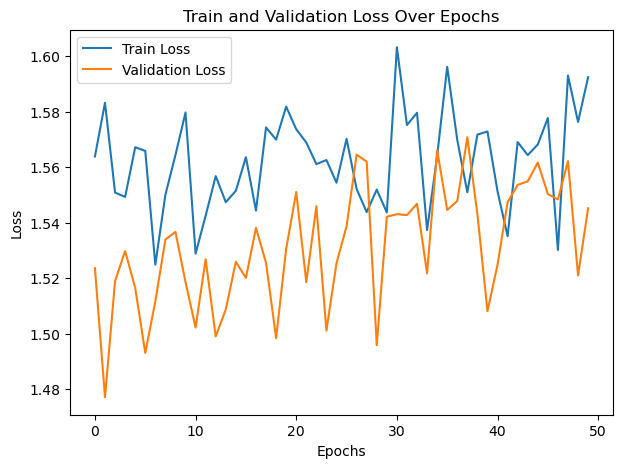

In [17]:
plt.figure(figsize=(7, 5))
plt.plot(data.index, data['train loss'], label='Train Loss')
plt.plot(data.index, data['valid loss'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss Over Epochs')
plt.legend()
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.show()


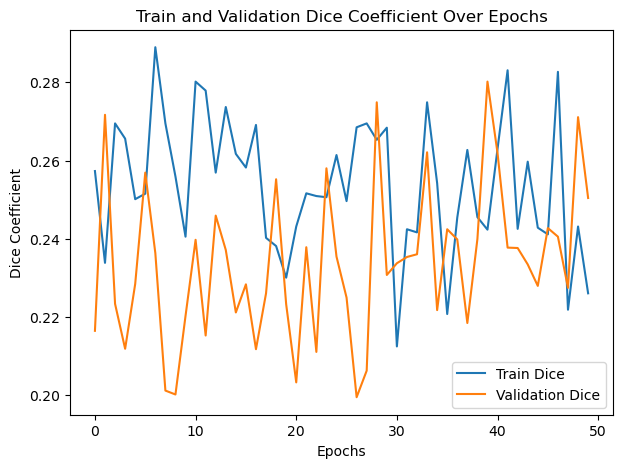

In [18]:
plt.figure(figsize=(7, 5))
plt.plot(data.index, data['train_dice'], label='Train Dice')
plt.plot(data.index, data['val_dice'], label='Validation Dice')

plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.title('Train and Validation Dice Coefficient Over Epochs')
plt.legend()
plt.show()


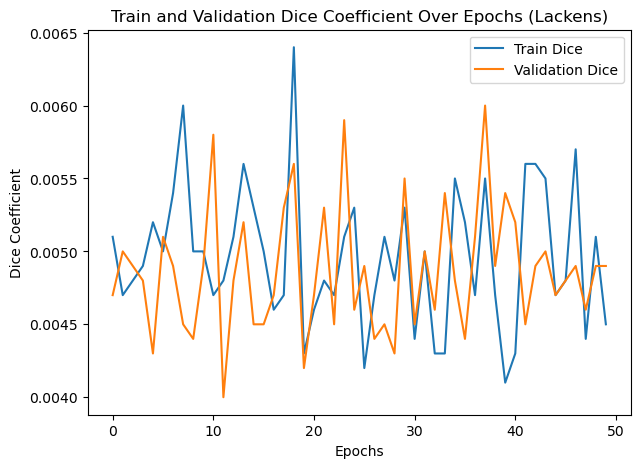

In [19]:
plt.figure(figsize=(7, 5))
plt.plot(data.index, data['train_l_dice'], label='Train Dice')
plt.plot(data.index, data['val_l_dice'], label='Validation Dice')

plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.title('Train and Validation Dice Coefficient Over Epochs (Lackens)')
plt.legend()
plt.show()


#### Evaluating on Test Data

In [20]:
model = UNetFT(1,1)
state_dict = torch.load(model_file)  # Load the state_dict
model.load_state_dict(state_dict)  # Load weights into the model
model = model.to(device)
model.eval()

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/var/folders/kj/50p9jhyx70135t3lmjp58l9h0000gn/T/ipykernel_95031/1638490350.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/p

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

Dice Coefficient: 0.1560479700565338
Dice Coefficient Lackens: 0.004356405697762966
IoU: 0.08517593890428543
IoU Lackens: 0.002181856893002987
Accuracy: 0.46275925636291504
Accuracy Lackens: 0.4960672855377197


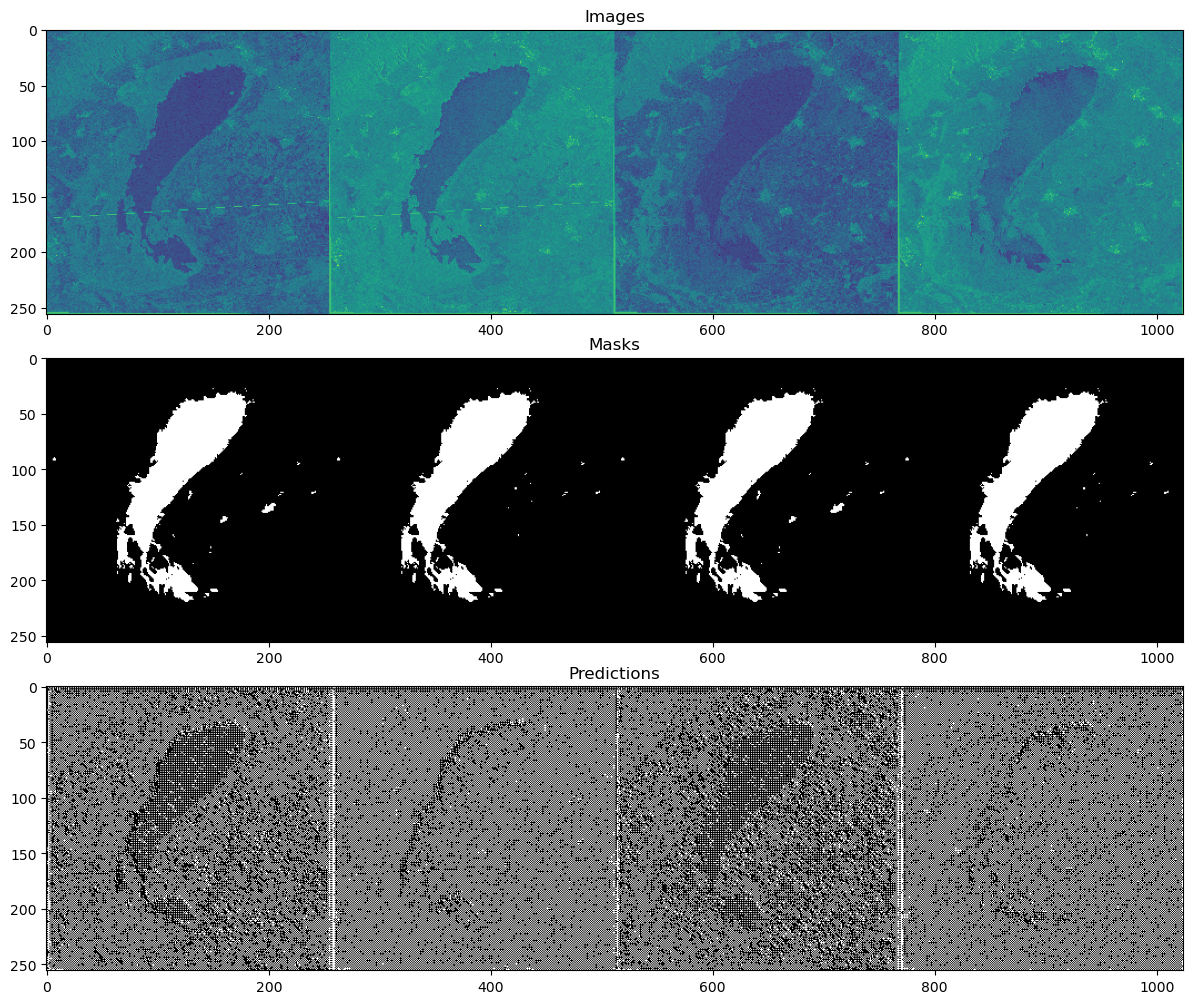

In [21]:
for images, masks, lacken_masks in testloader:
    with torch.no_grad():

        pred = model(images.to(device)).detach()
        pred = (pred > 0.5).float()


    display_batch(images, masks, pred,lacken_masks)
